# Multimodal Clustering Analysis

Sep 2019  
Dongmin Kim
[underkoo@kaist.ac.kr](mailto:underkoo@kaist.ac.kr)

**Expected input data:**
Process 900 dim latent feature of multi-modal instagram posts

**What this script does:**  
Explorative data analysis on the mult-modal latent. Checks for feature correlation (features = 900 dimesnsions), applies and visualized PCA, applies t-SNE on different data (raw, PCA, etc).


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import os
import copy
import collections
import seaborn as sns; sns.set()
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import Birch, SpectralClustering, AffinityPropagation, AgglomerativeClustering, MiniBatchKMeans, KMeans, DBSCAN, OPTICS
import matplotlib.colors as colors
import math
import time
import config

In [2]:
# magic line to have in-notebook interactive plots
%matplotlib notebook

In [3]:
#If you want to use a korean words, unblock it!
# path_gothic = './fonts/NanumBarunGothic.ttf'
# fontprop1 = fm.FontProperties(fname=path_gothic, size=3)

In [4]:
CONFIG = config.Config

## load latent feature

In [5]:
# load raw data
target_dataset = 'instagram0830'
df_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'latent_' + target_dataset + '.csv'), index_col=0, header=None, encoding='utf-8-sig')
df_data.index.name = 'short_code'
print('complete csv shape: ' + str(df_data.shape))
print(df_data.iloc[:100])

complete csv shape: (97672, 900)
                  1         2         3         4         5         6    \
short_code                                                                
Bh9eo6zh3WM -0.064532 -0.065540 -0.209814 -0.021301  0.014854 -0.080327   
BoSvvEPhZMS -0.189088 -0.061798  0.148479 -0.113556  0.240953 -0.126832   
BgIh0ZjhI-d -0.113356 -0.203790 -0.030494  0.073606  0.054041  0.020635   
BhUIQpoF6gk  0.045795  0.004372 -0.166487 -0.096258 -0.052713  0.068679   
BnTl4IYg40P -0.100515 -0.241264  0.242434  0.161904 -0.174477  0.215176   
BoI9HCMhZQu -0.085147 -0.140315 -0.037167  0.080107  0.123270  0.045918   
BrKyWdQlwo8  0.008656 -0.124482 -0.047757  0.050220  0.043262 -0.016874   
BruQRNjn34Y  0.207228  0.329502  0.230217 -0.133004  0.149729 -0.068669   
Br2aY8rH2mA -0.254777 -0.200513 -0.068824  0.154603 -0.082460 -0.252173   
Bn_hS-NAq_Y  0.020322 -0.173628 -0.302585  0.020675  0.376006  0.308826   
Br69C_Qgk1T -0.307152  0.085923 -0.157152 -0.217041  0.257655 -0.03

In [ ]:
print(df_data.describe())

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_data.boxplot()

In [6]:
#df_normalized = df_data.div((np.sqrt(np.sum(np.square(df_data), axis=1))), axis=0)
#df_normalized.sort_index(inplace=True)
#df_normalized.to_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_dataset + '.csv'), encoding='utf-8-sig')
df_normalized = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print('complete csv shape: ' + str(df_normalized.shape))
print(df_normalized.iloc[:100])

complete csv shape: (97672, 900)
                    1         2         3         4         5         6  \
short_code                                                                
B0-2hwnAUC7 -0.012487  0.032577  0.006710  0.004322  0.004575 -0.013601   
B0-3GYUJu9- -0.051407 -0.042300  0.018739 -0.027706 -0.012036  0.011060   
B0-3jyTB8AR  0.018414 -0.026582 -0.031688 -0.030548  0.001756 -0.054221   
B0-9JKVFedH  0.054895 -0.055354  0.019537  0.034644 -0.068899 -0.013263   
B0-AHdlnKtP  0.014341 -0.005719 -0.049690 -0.023413  0.017022 -0.047470   
B0-CPc3FpnC -0.038244  0.020616  0.007219  0.040018 -0.017713 -0.001997   
B0-D-SzhwCO  0.055614 -0.067110 -0.029208 -0.030717 -0.021035 -0.046967   
B0-E6Synzz7 -0.027706 -0.068817  0.006594  0.045105  0.034197 -0.009458   
B0-JKv-nxDa -0.044614  0.018956 -0.055227 -0.028931 -0.028658  0.063991   
B0-OOlUAdVQ  0.010811 -0.061261 -0.045836  0.052510  0.024702 -0.023058   
B0-QMh0lEHH  0.081120  0.015999  0.011998 -0.011755 -0.015640  0.03

In [ ]:
print(np.sqrt(np.sum(np.square(df_normalized), axis=1)))

In [ ]:
print(df_normalized.describe())

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_normalized.boxplot()

## PCA as dimensionality reduction

In [7]:
# PCA
pca = PCA(n_components=300)
df_pca_data = pd.DataFrame(pca.fit_transform(df_normalized))
df_pca_data.columns = ['PC' + str(i) for i in range(df_pca_data.shape[1])]
df_pca_data.index = df_data.index
print('singular_values_:\n' + str(pca.singular_values_))
print('components_:\n' + str(pca.components_))

# create PCA transformation DF
df_pca_transformation = pd.DataFrame(pca.components_).transpose()
df_pca_transformation.columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)]
df_pca_transformation.index = df_data.columns
#print(df_pca_transformation)

singular_values_:
[65.45085436 39.28083884 32.58430933 29.57455958 28.79108087 28.46161915
 28.01933586 27.04445211 26.76706394 26.10256803 25.45197145 25.12644332
 24.85206198 24.50437842 24.28268178 24.07463592 24.06621261 23.6575543
 23.37005866 23.22396634 23.15198199 22.93289181 22.67074284 22.29448509
 22.19367601 22.16006612 22.01003916 21.94867534 21.75830733 21.65755068
 21.56879216 21.49069719 21.38326381 21.17602937 21.09055806 21.01740025
 20.88650023 20.77308844 20.67730183 20.55607811 20.48505309 20.41431287
 20.34065063 20.2264769  20.06557938 19.98469945 19.91965526 19.77436594
 19.67567886 19.62579233 19.47083893 19.42996062 19.33028293 19.25527112
 19.0930544  19.05447537 18.99657391 18.94802088 18.80884714 18.76303408
 18.72121679 18.58013505 18.52040558 18.40820459 18.36217618 18.22699135
 18.17846804 18.12029381 18.04747224 18.02584213 17.8953867  17.87530483
 17.83664474 17.76985455 17.66759171 17.55255626 17.53274116 17.4531192
 17.40250995 17.3181254  17.2366805

<IPython.core.display.Javascript object>


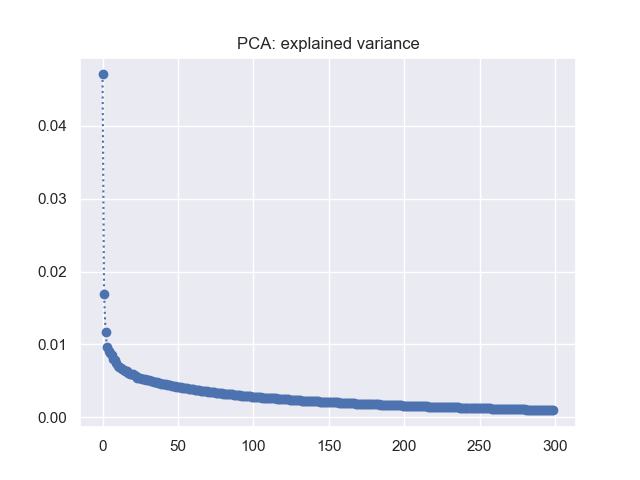

<IPython.core.display.Javascript object>


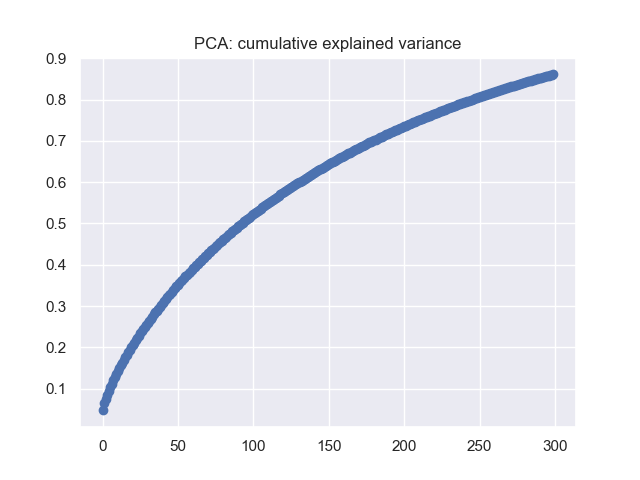

Text(0.5, 1.0, 'PCA: cumulative explained variance')

In [8]:
# PCA: plot variance explained
plt.figure()
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle=':')
plt.title('PCA: explained variance')

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('PCA: cumulative explained variance')

In [9]:
def scatterplot_pointlabels(df_twocols, markersize=None):
    # basic scatterplot
    fig = plt.figure()
    plt.plot(df_twocols.iloc[:, 0], df_twocols.iloc[:, 1], marker='.', linestyle='None', markersize=markersize)

<IPython.core.display.Javascript object>


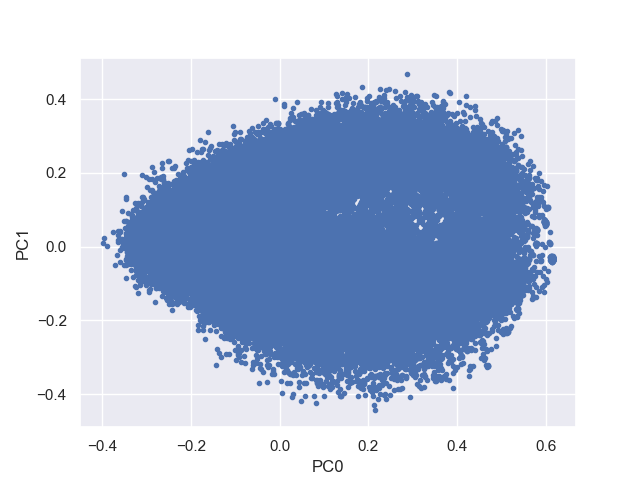

<IPython.core.display.Javascript object>


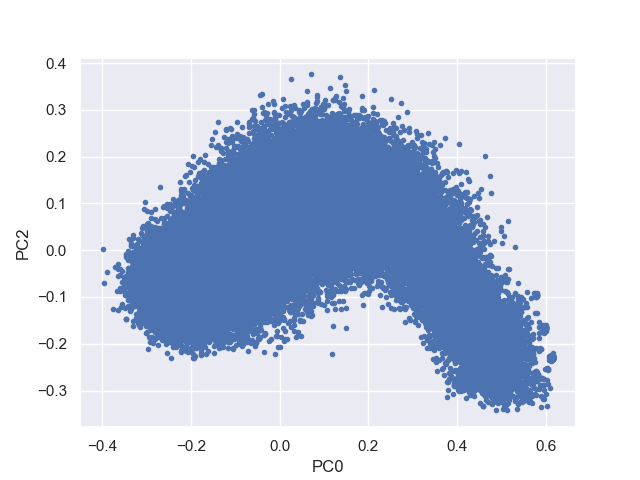

<IPython.core.display.Javascript object>


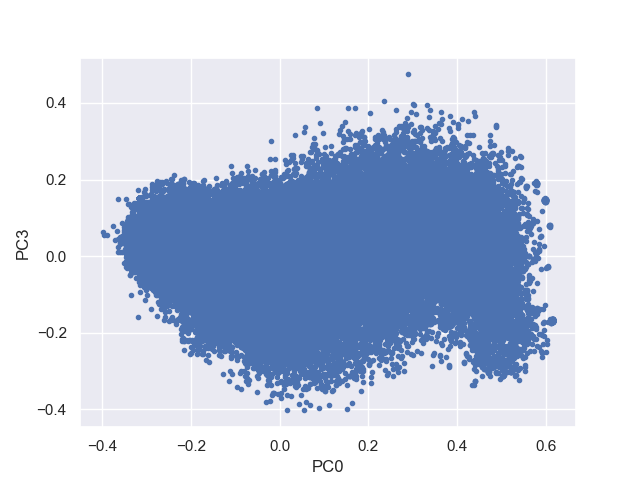

<IPython.core.display.Javascript object>


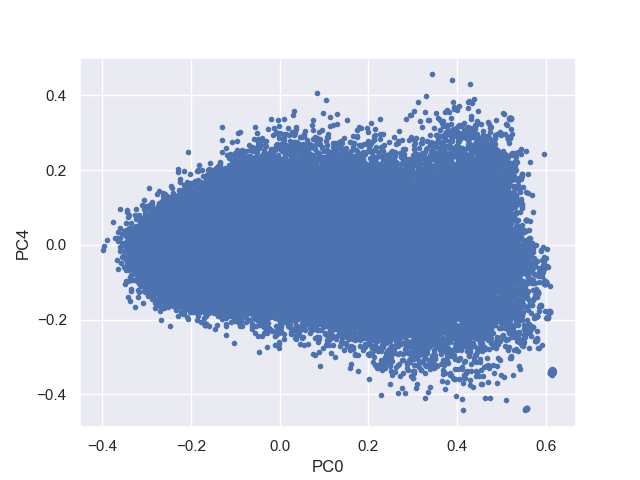

<IPython.core.display.Javascript object>


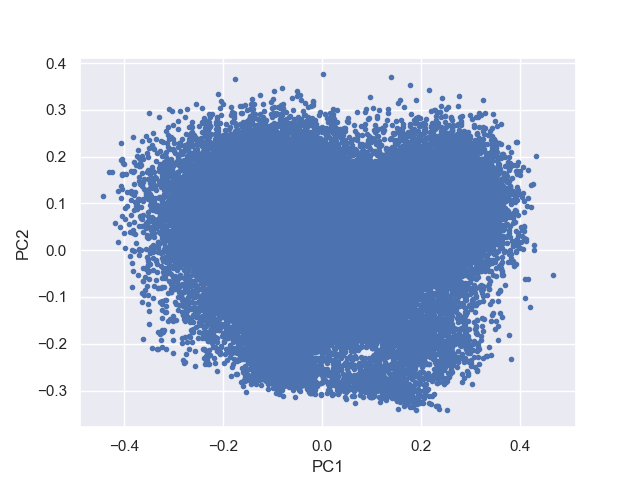

<IPython.core.display.Javascript object>


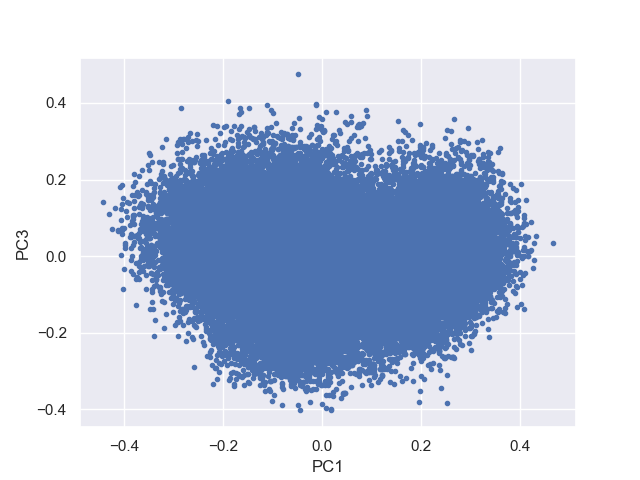

<IPython.core.display.Javascript object>


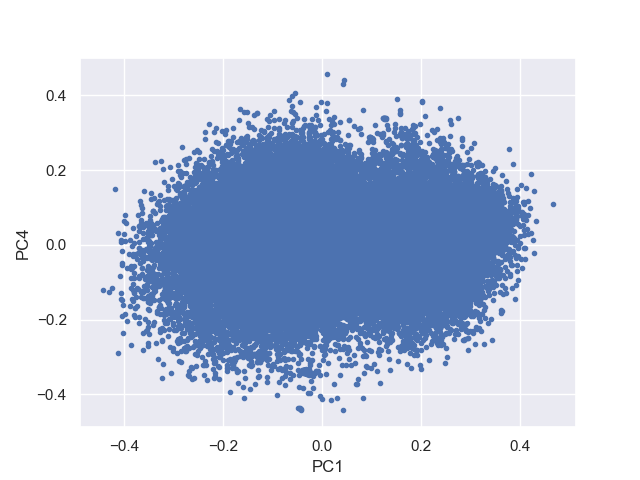

<IPython.core.display.Javascript object>


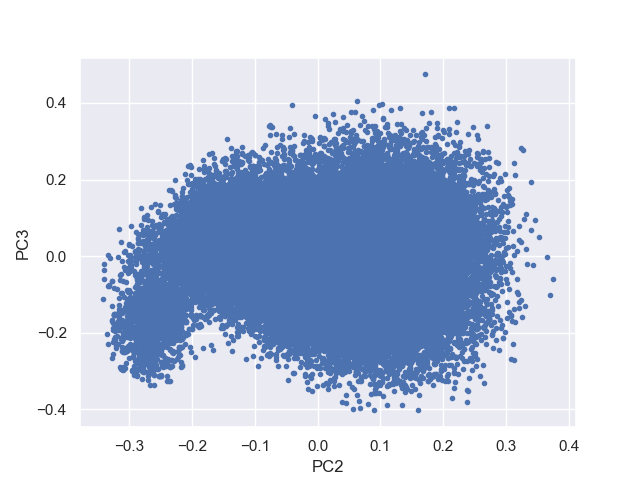

<IPython.core.display.Javascript object>


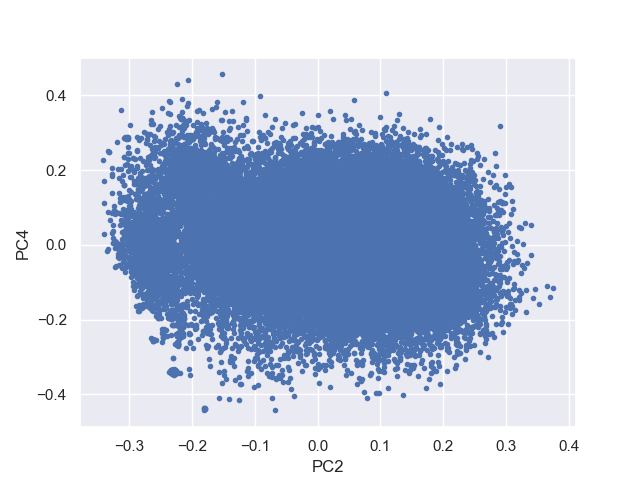

<IPython.core.display.Javascript object>


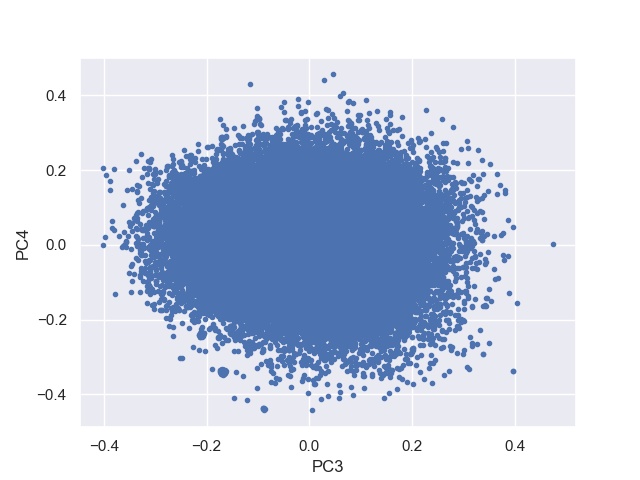

In [10]:
# plot PC dimensions
for dimen1 in range(0, 5):
    for dimen2 in range(dimen1 + 1, 5):
        # subset dataframe to the PC columns we need
        df_tmp = df_pca_data.iloc[:, [dimen1, dimen2]]
        
        # plot without labels
        scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        plt.xlabel(df_tmp.columns[0])
        plt.ylabel(df_tmp.columns[1])
        
        # plot with labels
        #scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        #plt.xlabel(df_tmp.columns[0])
        #plt.ylabel(df_tmp.columns[1])

In [12]:
df_pca_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_dataset + '.csv'), encoding='utf-8-sig')
#df_pca_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(df_pca_data.iloc[:100])

                  PC0       PC1       PC2       PC3       PC4       PC5  \
short_code                                                                
Bh9eo6zh3WM  0.024564 -0.346317  0.106486  0.089173 -0.030701 -0.259525   
BoSvvEPhZMS -0.084186 -0.022803  0.013136 -0.030584 -0.107440  0.025779   
BgIh0ZjhI-d  0.100100  0.270996  0.057465  0.029289  0.113070 -0.030468   
BhUIQpoF6gk  0.016242 -0.008416  0.041442  0.030646 -0.008390 -0.044972   
BnTl4IYg40P -0.061832  0.162855  0.039180  0.035028 -0.032528  0.033538   
BoI9HCMhZQu -0.145806 -0.071806 -0.048844  0.077128 -0.019621 -0.013101   
BrKyWdQlwo8  0.273346 -0.044730  0.003508  0.052879  0.048868  0.083098   
BruQRNjn34Y  0.535839  0.116276 -0.292675 -0.195240 -0.045137 -0.142358   
Br2aY8rH2mA -0.209727  0.063186 -0.009186  0.035459 -0.053480 -0.012860   
Bn_hS-NAq_Y -0.126464  0.063413  0.026279  0.036198 -0.006608  0.022752   
Br69C_Qgk1T -0.220607 -0.044542 -0.110787  0.029432  0.021537 -0.048217   
BsFudrehNdL -0.218448 -0.

## Downsample

In [ ]:
def downsampling(df_data, num_samples=100):
#     idx = int(len(df_data)/num_samples)
#     idx_list = [x for x in range(0, len(df_data), idx)]
#     return df_data.iloc[idx_list]
    return df_data.sample(num_samples)

In [ ]:
ds_data = downsampling(df_data, 10000)

In [ ]:
#ds_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'ds_' + target_dataset + '.csv'), encoding='utf-8-sig')
ds_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'ds_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(ds_data)

## t-SNE

In [13]:
def do_tsne(tsne_object, data_to_pass):
    data_tsne = pd.DataFrame(tsne_object.fit_transform(data_to_pass))
    data_tsne.index = data_to_pass.index
    data_tsne.columns = [['tsne1', 'tsne2']]
    return data_tsne

In [37]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
start_time = time.time()
#tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), df_pca_data)
tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=1000, learning_rate=100, n_iter=1000, random_state=42, n_jobs=4, verbose=1), df_pca_data)
print("time elapsed: " + str(time.time()-start_time))

time elapsed: 4259.269072532654


<IPython.core.display.Javascript object>


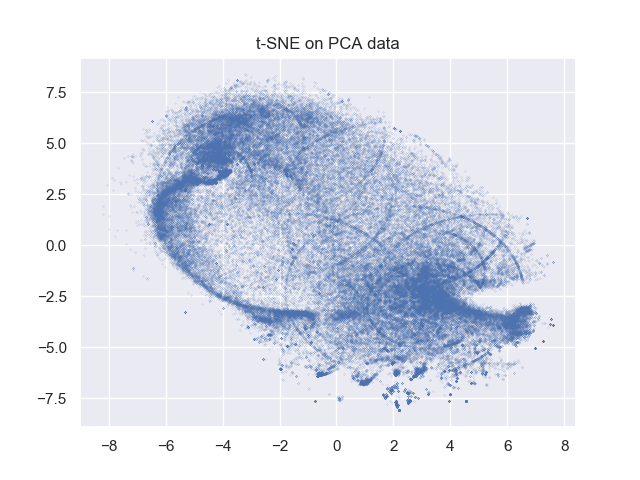

In [36]:
# plot t-SNE with PCA
scatterplot_pointlabels(tsne_pca, 0.2)
plt.title('t-SNE on PCA data')
plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_dataset + '.svg'))


In [34]:
tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), encoding='utf-8-sig')
#tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(tsne_pca.iloc[:100])

                tsne1     tsne2
short_code                     
Bh9eo6zh3WM -0.117424  2.640215
BoSvvEPhZMS  0.017703 -2.201380
BgIh0ZjhI-d -2.802391  0.282228
BhUIQpoF6gk  0.114180  1.159702
BnTl4IYg40P  0.482407 -0.420549
BoI9HCMhZQu  0.840395 -1.797056
BrKyWdQlwo8 -1.878745  2.671593
BruQRNjn34Y -2.235737  2.193147
Br2aY8rH2mA  0.248505 -3.315357
Bn_hS-NAq_Y  2.710580 -1.576393
Br69C_Qgk1T  0.846888 -2.123835
BsFudrehNdL  0.866721 -1.333522
BlMgEb1AxuD  0.950221 -1.850714
BnTf4-wgGvu -2.738577  1.803415
Bgx1HkjFoq_ -1.366707 -0.261819
BhUnpHaDp-c -2.904310  0.784796
BnyNSN0H5EM -2.551032  1.868083
BoG5pQpHD92 -2.978907  1.706513
BlK0wY_HAn8  0.269228 -0.369096
Bnn9mSzFqrv  0.273656 -0.369612
BntC-EtF0mX -1.717871  2.788127
BjPN_94AT_v  2.195204 -1.296182
BjSC2lEn7NH -2.743936  0.220848
BjjtqV6Aqic  0.845091 -1.490627
BxZ20ODAh9u  2.925278 -1.501918
Bx8yyX2jgTC -0.778800  3.002803
Byxy79dhATV -1.081344  3.101635
ByNtIv1jl5A  0.640569 -0.557702
Bxc5LFOHGiI  0.939968 -1.660540
BxM6YLfF

In [ ]:
# on raw data
# TODO tune the learning rate and the iterations (rest should be ok i guess)
# start_time = time.time()
# tsne_raw = do_tsne(MulticoreTSNE(n_components=2, perplexity=400, early_exaggeration=12.0, learning_rate=100, n_iter=10000, random_state=42, n_jobs=4), data)
# print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with raw data
# scatterplot_pointlabels(tsne_raw, plot_labels=False)
# plt.title('t-SNE on raw data')
# scatterplot_pointlabels(tsne_raw)
# plt.title('t-SNE on raw data')

## Spectral Clustering

In [31]:
#temp
start_time = time.time()
temp_clustering = KMeans(n_clusters = 24, random_state=42).fit(df_normalized)
labels = temp_clustering.labels_
print("time elapsed for clustering: " + str(time.time()-start_time))
start_time = time.time()
print(silhouette_score(df_normalized, labels, metric = 'cosine'))
print("time elapsed for silhouette_score: " + str(time.time()-start_time))

time elapsed for clustering: 806.8772060871124
-0.022435104646895646
time elapsed for silhouette_score: 282.75083446502686


In [24]:
def clustering_score(X, max_num_clusters=10):
    sse = []
    sil = []
    for k in range(2, max_num_clusters + 1):
        start_time = time.time()
        temp_clustering = KMeans(n_clusters = k, random_state=42).fit(X)
        print("time elapsed for clustering: " + str(time.time()-start_time))
        labels = temp_clustering.labels_
        sse.append(temp_clustering.inertia_)
        start_time = time.time()
        sil.append(silhouette_score(X, labels, metric = 'cosine'))
        print("time elapsed for silhouette_score: " + str(time.time()-start_time))
    return sse, sil

In [15]:
def sse_distance(sse):
    distance = []
    last = len(sse) - 1
    for i in range(1, last):
        _distance = abs((sse[last] - sse[0]) * i - (last - 0) * sse[i] + last * sse[0] - sse[last] * 0) / math.sqrt(math.pow((sse[last] - sse[0]),2) + math.pow((last - 0),2))
        distance.append(_distance)
    return distance

In [25]:
max_num_clusters = 12
sse, sil = clustering_score(df_normalized, max_num_clusters)
fig = plt.figure()
plt.plot(range(2, max_num_clusters + 1), sse, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SSE')
distance = sse_distance(sse)
fig = plt.figure()
plt.plot(range(3, max_num_clusters), distance, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SSE-distance')
fig = plt.figure()
plt.plot(range(2, max_num_clusters + 1), sil, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SIL')

time elapsed for clustering: 100.24085211753845


KeyboardInterrupt: 

In [ ]:
num_clusters = 21

In [ ]:
#labeling points of tnse clusters
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=3, fontproperties=fontprop1)

In [ ]:
def count_percentage(cluster_labels):
    count = collections.Counter(cluster_labels)
    for k in count:
        print("cluster {} : {:.2%}".format(str(k), count[k]/len(cluster_labels)))

In [ ]:
def do_clustering(df, tsne):
        start_time = time.time()
        #clustering = Birch(n_clusters=21).fit(df_data)
        #clustering = DBSCAN(eps=3, min_samples=5).fit(tsne_pca)
        #clustering = SpectralClustering(n_clusters=num_clusters, random_state=42).fit(df)
        #clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(data.loc[filtered_columns.index,:])# data, df_pca_data
        clustering = KMeans(n_clusters=num_clusters).fit(df)# data, df_pca_data
        count_percentage(clustering.labels_)
        print(clustering.labels_)
        print("time elapsed: " + str(time.time()-start_time))
        dist = copy.deepcopy(tsne)
        dist = dist.loc[df.index]
        dist['cluster'] = clustering.labels_
        return dist

In [ ]:
#Spectral clustering
#For using 'amg' you should install pyamg in you local computer.
# Check the component at
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
clustered_df = do_clustering(tsne_pca, tsne_pca)

In [ ]:
clustered_df = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_birch_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(clustered_df.iloc[:100])

In [ ]:
def plot_spectral_clustering(dataframe, markersize=None):
    # plot spectrac clustering result
    # without label
    #scatterplot_pointlabels(dataframe[['x', 'y']], markersize)
    # better colors
    plt.figure(figsize=(13.2,9.6))
    color_dict = {v: k for v, k in enumerate(sns.color_palette("Paired", num_clusters))}
    sns_plot = sns.scatterplot(x="x", y="y", hue='cluster_id', palette=color_dict, data=dataframe, marker='.', s=markersize)
    plt.savefig(os.path.join(CONFIG.SVG_PATH, 'clustering_' + target_dataset + '.svg'))

In [ ]:
# put clustering info into df
df_clustered_spectral = pd.DataFrame({'x': clustered_df.tsne1.squeeze(), 
                                      'y': clustered_df.tsne2.squeeze(), 
                                      'cluster_id': clustered_df.cluster.squeeze()})
# debug prints
#print(df_clustered_spectral.dtypes)
plot_spectral_clustering(df_clustered_spectral, 30)       
#ds_clustered_spectral = downsampling(df_clustered_spectral, 5000)
#plot_spectral_clustering(ds_clustered_spectral, 0.2)       
# print(df_clustered_spectral.iloc[:10, :])
# df_clustered_spectral['cluster_id'].describe() # 30 integer clusters